# 2018-10-19 Synthetizing, cleaning, moving on
# The slow part of the code is mostly the rendering, otherwise it's superfast, even on my laptop
On va :
* Reprendre les modifs de Laurent pour les faire marcher avec mon code, OK
* Essayer le multifiltre selon ce schéma, OK
* Faire marcher les convos, OK OK
* Tenter de transformer tout ça en output sur un neurone ??? Pas OK !

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm

def find_middle(a_list):
    middle = len(a_list)/2
    return a_list[int(middle)]

# Filtre spatial, sans theta

In [2]:
# Un premier filtre, spatial avec center-surround (voir et citer MARR ?)


def spatial_filter(wx=5., wy=5., xres=.1, yres=.1, sigma_center=1., sigma_surround=1.2,
                   x_trans=0, y_trans=0, theta=0, end_multiplier=-1.):
    ''' wx, wy : x/y width
    xres, yres : x/y resolution
    sigma_center : U.A related to the center of the circle
    sigma_surround : U.A related to the surround of of the circle
    x_trans, y_trans : 0, 0 #translation of the filter
    end_mutiplier : decreases the spatial filter response and triggers ON(negative value) or OFF(positives)
    center-surround fields
    '''
    x = np.arange((-wx+x_trans), (wx+x_trans), xres)
    y = np.arange((-wy+y_trans), (wy+y_trans), yres)
    X,Y = np.meshgrid(x,y)

    radius = np.sqrt((X-x_trans)**2 + (Y-y_trans)**2)
    center = (1.0 / sigma_center**2) * np.exp(-.5*(radius / sigma_center)**2)
    surround = (1.0 / sigma_surround**2) * \
        np.exp(-.5*(radius / sigma_surround)**2)

    Z = surround - center
    Z *= end_multiplier
    return X, Y, Z

# Filtre temporel, sans division bizarres et avec une inertie à chaque réponse

In [3]:
def temporal_filter(t = 1 , response_time = 175, refrac_time = 50,
                   K1 = .92, c1 = 0.2, n1 = 7, t1 = -6,
                   K2 = .2, c2 = .12, n2 = 8, t2 = -6,
                   baseline = 0.001, gain = 90):
    '''
    Arguments :
    --> time = time for which the filter's reponse is calculated
    --> total_time = time the filter takes to do a full response, starting from 0, peaking, undershooting
    and going to 0 again
    --> refrac_time = refraction time after which the filter can be activated again
    --> other params are as f(x) = K * [ (c*(t-1))**2 * e^(-c1(t-t1)) ] / [ (n**2) * e^-n]
    (see wikipedia for formula)
    -->-->K relates to the height, c to the opening
    '''
    
    #t = np.arange(0, total_time*t_res, t_res)
    p = baseline
    p += K1 * ( (c1 * (t - t1))**n1 * np.exp(-c1 * (t-t1))) / (n1**2)*np.exp(-n1)
    p -= K2 * ( (c2 * (t - t2))**n2 * np.exp(-c2 * (t-t2))) / (n2**2)*np.exp(-n2)
    return p*gain #oups je me suis planté d'un facteur 90, c'est un sacré miss

def activation_temporal_filter(X,Y,Z,t,filtertime, baseline,
                            activation_threshold, refractory_period,
                            stim, stimtime):
    '''
    An activation-based temporal filter, that only starts after the associated spatial filter as detected
    something above the activation_threshold. It is used to convert a regular temporal filterinto a more 
    realist one, in the sense it works like an adaptative response and not an oscillator
    Args :
    --> X,Y,Z = Spatial filter
    --> t, filtertime, baseline = Temporal filter and associated total time, as well as the baseline
    --> activation_threshold = Threshod above which the spatial filter is activated
    --> refractory_period = Period during which the modified temporal filter becomes inactive
    --> stim, stimtime = Stimulus and associated stimulus total time, usually equals to the filtertime
    '''
    
    v2_filter = []
    deactivation_delay = 0
    for i in np.linspace(0,filtertime-1, filtertime) :
        activation = np.max(Z*stim[:,:,int(i)])

        if deactivation_delay == 0 :
            if activation < activation_threshold : #the spatial hasn't seen anything
                v2_filter.append(baseline) #don't forget the 90 corrective factor
            else : #we start a new countdown
                deactivation_delay = refractory_period
                print(refractory_period)
                print('The spatial filter started detecting something at %s ms' % int(i))
        else : #we're doing a reponse
            deactivation_delay -=1
            v2_filter.append(temporal_filter(refractory_period-deactivation_delay))
            
    return v2_filter

Text(0.5,1,'Temporal filter with a non-zero baseline')

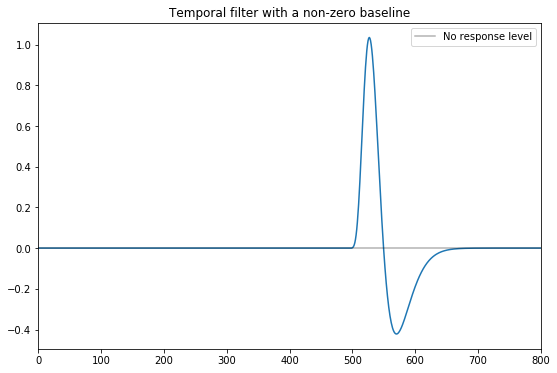

In [4]:
total_time = 800
ys = []
t = [temporal_filter(i, baseline = 0) for i in np.linspace(0,total_time, total_time)]
spikes = np.zeros(total_time)
spikes[500] = 1

ys = np.convolve(t, spikes)

plt.figure(figsize = (9,6))
plt.plot(ys)
plt.xlim(0, 800)
plt.axhline(0, color = 'k', alpha = .3, label = 'No response level')
plt.legend(loc = 1)
plt.title('Temporal filter with a non-zero baseline')

In [5]:
wx, wy = 5., 5.
xres, yres = .1, .1

X, Y, Z = spatial_filter()
total_time = 800
ys = []
t = [temporal_filter(i, baseline = 0) for i in np.linspace(0,total_time, total_time)]


np.random.seed(42)
stimuli = 2.*np.random.randint(2, size = (int(wx/(xres/2)), int(wy/(yres/2)), total_time) )
stimuli *= 0.01
signal = np.zeros_like(stimuli)
signal[50, 50, 18] = 1
signal[50, 50, 230] = 1
stimuli += signal

activations = []
for i in np.linspace(0, total_time-1, total_time):
    activations.append(np.max(stimuli[:,:,int(i)]*Z))

Text(0.5,1,'Temporal filter with a non-zero baseline')

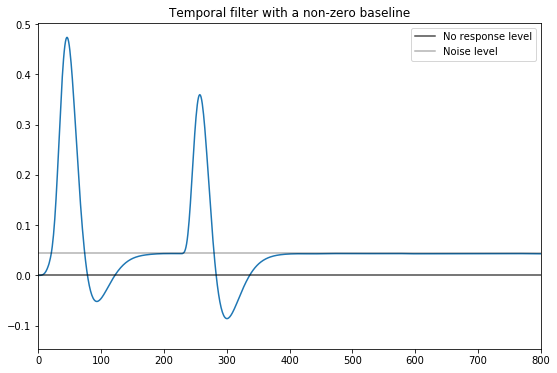

In [6]:
total_time = 800
ys = []
t = [temporal_filter(i, baseline = 0) for i in np.linspace(0,total_time, total_time)]

ys = np.convolve(t, activations)

plt.figure(figsize = (9,6))
plt.plot(ys)
plt.xlim(0, 800)
plt.axhline(0, color = 'k', alpha = .7, label = 'No response level')
plt.axhline(0.045, color = 'k', alpha = .3, label = 'Noise level')
plt.legend(loc = 1)
plt.title('Temporal filter with a non-zero baseline')

# Filtre spatiotemporel maintenant

In [7]:
st = Z[:, :, None] * ys[None, None, :] #ys qui est la convolution des signaux spatiaux par le temporel

interesting_times [0, 37, 75, 112, 150, 187, 225, 262, 300]


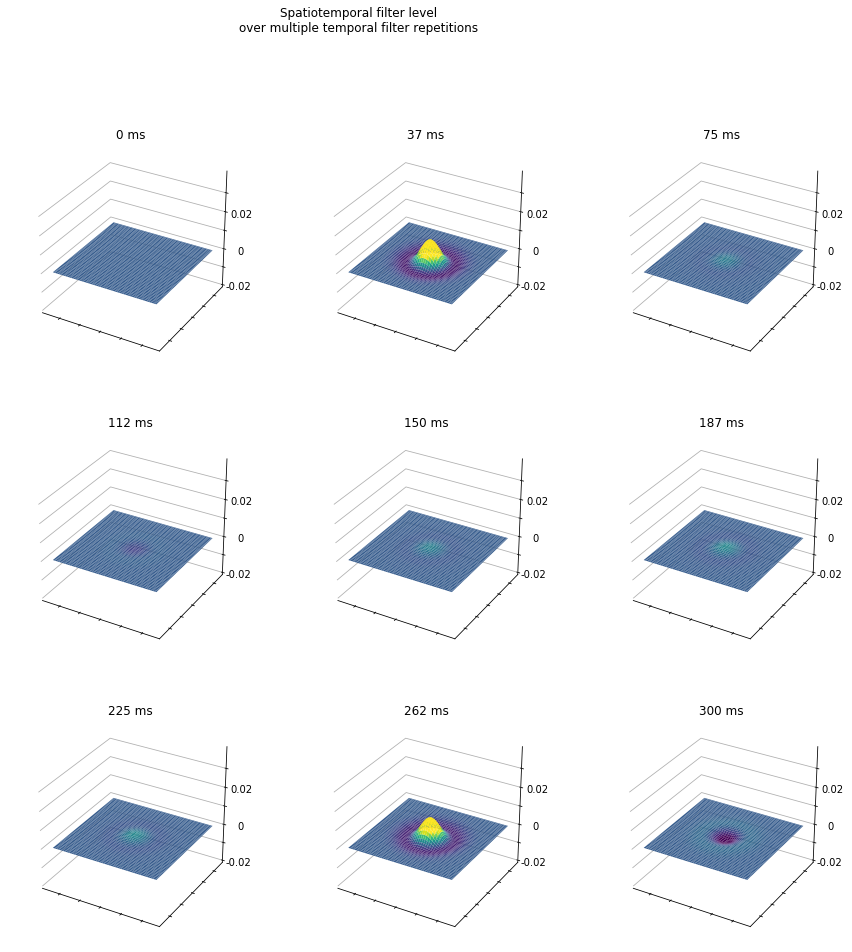

In [8]:
# c'est pas propre mais j'ai eu des tas de pb avec matplotlib alors on va la jouer comme ça
# pas besoin de s'embêter avec les colormaps vu que c'est la meme que celle de la 3D, qui va surement
# finir a coté sur le rapport
plt.figure(figsize=(15, 15))
#plt.subplots_adjust(bottom=.7, top=.97, wspace=.02, hspace=.02, right=.75)

interesting_times = [int(k) for k in np.linspace(0, 300, 9)]

print('interesting_times', interesting_times)
for i, t0 in enumerate(interesting_times):
    ax = plt.subplot(3, 3, i+1, aspect='equal', projection='3d')
    ax.plot_surface(X, Y, st[:, :, t0], vmin=-.02, vmax=.05,
                    cmap=plt.cm.viridis)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_zticklabels([-.02, '', 0, '', 0.02, '', 0.04, ''])

    ax.set_zlim(-.2, .4)
    ax.xaxis._axinfo["grid"]["color"] = (1, 1, 1, 0)
    ax.yaxis._axinfo["grid"]["color"] = (1, 1, 1, 0)
    #ax.zaxis._axinfo["grid"]["color"] = (1,1,1,0)

    ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.set_title('%s ms' % (t0), color='k')

#plt.tight_layout()
plt.suptitle(
    'Spatiotemporal filter level\nover multiple temporal filter repetitions', x=.45, y=.99)
plt.show()
#plt.savefig('./figs/2018_10_12_SpatioTemporal_filter3D_800ms.pdf', format = 'pdf', dpi = 200,bbox_inches = 'tight' )

# Filtres multiples avec découpage de l'image avant

In [9]:
stimuli = []
for i in range(total_time+1):
        xx, yy = np.mgrid[:100, :100]
        circle = (xx - 50) ** 2 + (yy - int(i/8)) ** 2
        japanese_flag = (circle < 100)
        stimuli.append(japanese_flag)

############
# Constants
############
baseline = 0.001
total_time = 800
filter_size = 5.
n = 10

nbr_filters = 3
filters_coordinates = [ [50,40], [50,50], [50,60] ]

sub_imgs = [] #here we subsample the images
for i, fts in enumerate(filters_coordinates):
    ims_shown = []
    for stim in stimuli :
        im_shown = stim[int(filters_coordinates[i][0]-filter_size):int(filters_coordinates[i][0]+filter_size),
                       int(filters_coordinates[i][1]-filter_size):int(filters_coordinates[i][1]+filter_size)]
        ims_shown.append(np.kron(im_shown, np.ones((n,n)))) #the kron product upscales the matrix
    sub_imgs.append(ims_shown)

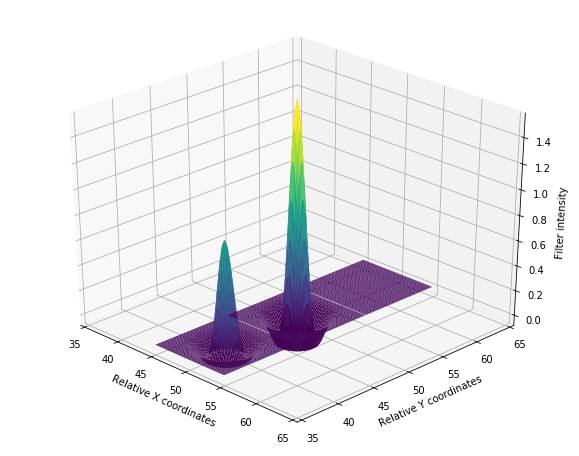

In [10]:
fig = plt.figure(figsize = (10,8))
ax = fig.add_subplot(111, projection = '3d')
ax.view_init(azim = -45, elev=30)
ax.set_xlim(35,65)
ax.set_ylim(35,65)
ax.set_zlim(-.05,1.55)


###########
# Multiple filters 
###########

convo_list = []
for filt in range(nbr_filters) :
    X,Y,Z = spatial_filter(wx = filter_size, wy=filter_size,
                           x_trans= filters_coordinates[filt][0],
                          y_trans = filters_coordinates[filt][1]) 
    temporal = [temporal_filter(i) for i in np.linspace(0,total_time, total_time)]

    ax.set_zlabel('Filter intensity')
    ax.set_xlabel('Relative X coordinates') 
    ax.set_ylabel('Relative Y coordinates')
    
    activations = []
    for i in np.linspace(0, total_time-1, total_time):
        activations.append(np.max(sub_imgs[filt][int(i)]*Z))
    
    ys = np.convolve(t, activations)
    st = Z[:, :, None] * ys[None, None, :]
    ax.plot_surface(X,Y,st[:,:,350], cmap = plt.cm.viridis,
                   vmin = -.05, vmax = 1.5)
    
    convo_list.append(ys)

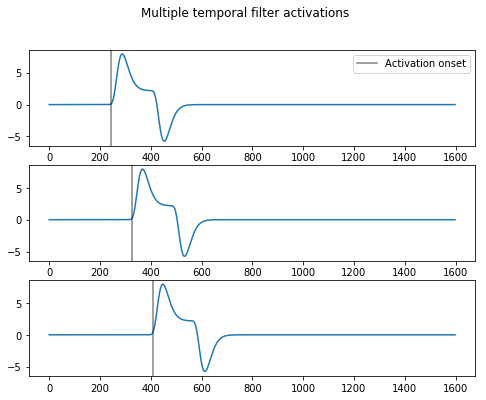

In [11]:
fig, axs = plt.subplots(nrows = 3, figsize = (8,6))
axs[0].plot(convo_list[0])
axs[0].axvline(245, color = 'k', alpha = .5, label = 'Activation onset')
axs[0].legend()

axs[1].plot(convo_list[1])
axs[1].axvline(325, color = 'k', alpha = .5, label = 'Activation onset')

axs[2].plot(convo_list[2])
axs[2].axvline(410, color = 'k', alpha = .5, label = 'Activation onset')

plt.suptitle('Multiple temporal filter activations')
plt.savefig('./figs/2018_10_22_Multiple_temporal_activations.pdf', format = 'pdf', dpi = 200, bbox_inches = 'tight')

# Filtres multiples avec convolution sur la bonne zone

In [12]:
stimuli = []
for i in range(total_time+1):
        xx, yy = np.mgrid[:100, :100]
        circle = (xx - 50) ** 2 + (yy - int(i/8)) ** 2
        japanese_flag = (circle < 100)
        stimuli.append(japanese_flag)

############
# Constants
############
baseline = 0.001
total_time = 800
filter_size = 5.

nbr_filters = 3
filters_coordinates = [ [50,40], [50,50], [50,60] ]

Making filters: 100%|██████████| 3/3 [00:02<00:00,  1.40it/s]


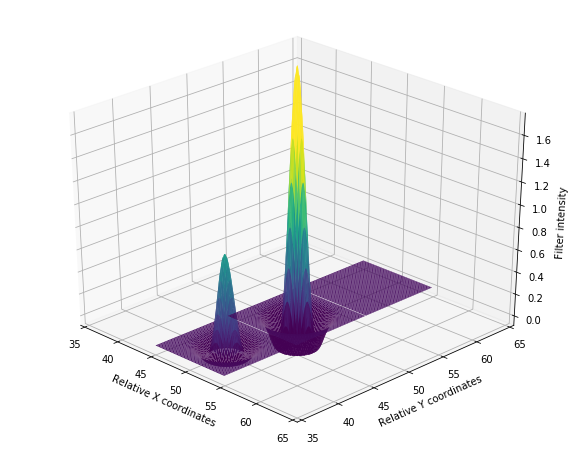

In [13]:
fig = plt.figure(figsize = (10,8))
ax = fig.add_subplot(111, projection = '3d')
ax.view_init(azim = -45, elev=30)
ax.set_xlim(35,65)
ax.set_ylim(35,65)
ax.set_zlim(-.05,1.75)


###########
# Multiple filters 
###########

convo_list = []
for filt in tqdm(range(nbr_filters), 'Making filters') :
    X,Y,Z = spatial_filter(wx = filter_size, wy=filter_size,
                           x_trans= filters_coordinates[filt][0],
                          y_trans = filters_coordinates[filt][1]) 
    temporal = [temporal_filter(i) for i in np.linspace(0,total_time, total_time)]

    ax.set_zlabel('Filter intensity')
    ax.set_xlabel('Relative X coordinates') 
    ax.set_ylabel('Relative Y coordinates')
    
    #Convolution coordinates, centered around the filter and the size of the filter space
    X_convo_minus = int(filters_coordinates[filt][0]-filter_size)
    X_convo_plus = int(filters_coordinates[filt][0]+filter_size)
    Y_convo_minus = int(filters_coordinates[filt][1]-filter_size)
    Y_convo_plus = int(filters_coordinates[filt][1]+filter_size)
    
    activations = []
    for i in np.linspace(0, total_time-1, total_time):
        activations.append(np.max(stimuli[int(i)][X_convo_minus:X_convo_plus,Y_convo_minus:Y_convo_plus] \
                                  *Z[X_convo_minus:X_convo_plus,Y_convo_minus:Y_convo_plus]))
    
    ys = np.convolve(t, activations)
    st = Z[:, :, None] * ys[None, None, :]
    ax.plot_surface(X,Y,st[:,:,350], cmap = plt.cm.viridis,
                   vmin = -.05, vmax = 1.5)
    
    convo_list.append(ys)

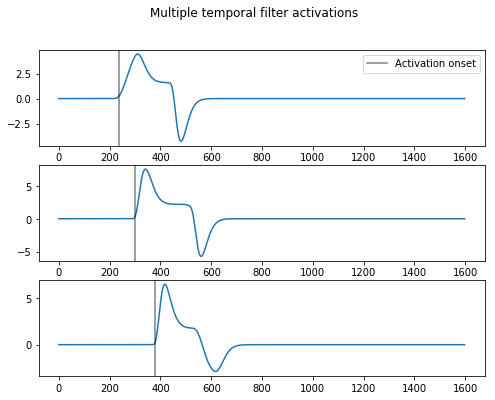

In [14]:
fig, axs = plt.subplots(nrows = 3, figsize = (8,6))
axs[0].plot(convo_list[0])
axs[0].axvline(235, color = 'k', alpha = .5, label = 'Activation onset')
axs[0].legend()

axs[1].plot(convo_list[1])
axs[1].axvline(300, color = 'k', alpha = .5, label = 'Activation onset')

axs[2].plot(convo_list[2])
axs[2].axvline(380, color = 'k', alpha = .5, label = 'Activation onset')

plt.suptitle('Multiple temporal filter activations')
plt.savefig('./figs/2018_10_22_Multiple_temporal_activations_convolutions.pdf', format = 'pdf', dpi = 200, bbox_inches = 'tight')

# Larger simulation using a 4x4 grid
Matplotlib is fucking awful for 3D plots so more than that is unreadable

In [15]:
coo_min, coo_max = 40,60
grid_res = 5

#mega one-liner de la mort, merci stack
#/questions/32208359/is-there-a-multi-dimensional-version-of-arange-linspace-in-numpy
xy = np.mgrid[coo_min:coo_max:grid_res, coo_min:coo_max:grid_res].reshape(2,-1).T

print('xy.shape',xy.shape)

xy.shape (16, 2)


In [16]:
stimuli = []
for i in range(total_time+1):
        xx, yy = np.mgrid[:100, :100]
        circle = (xx - 50) ** 2 + (yy - int(i/8)) ** 2
        japanese_flag = (circle < 100)
        stimuli.append(japanese_flag)

############
# Constants
############
baseline = 0.001
total_time = 800
filter_size = 3. #c'est plus proche de la vrai valeur d'angle visuel ? Demander à Laurent
filter_res = .1

filters_coordinates = xy

Making filters: 100%|██████████| 16/16 [00:05<00:00,  3.08it/s]


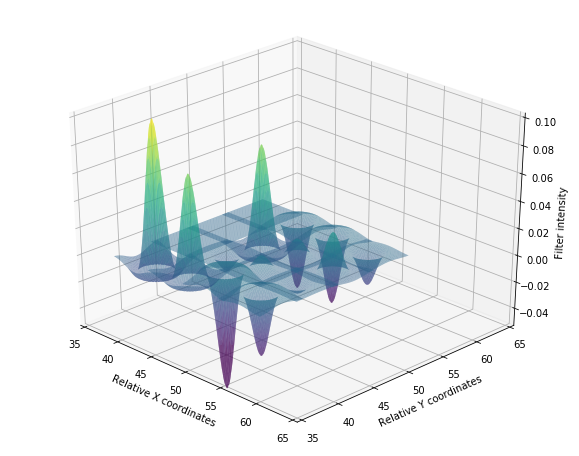

In [19]:
fig = plt.figure(figsize = (10,8))
ax = fig.add_subplot(111, projection = '3d')
ax.view_init(azim = -45, elev=30)
ax.set_xlim(35,65)
ax.set_ylim(35,65)
ax.set_zlim(-.05,.1)


###########
# Multiple filters 
###########

convo_list = []
st_list = [] # a list of spatiotemporal filters for tests with plotting
Xs = []
Ys = []
Sts = []

for filt in tqdm(range(len(filters_coordinates)), 'Making filters') :
    X,Y,Z = spatial_filter(wx = filter_size, wy=filter_size,
                           xres = filter_res, yres = filter_res,
                           x_trans= filters_coordinates[filt][0],
                          y_trans = filters_coordinates[filt][1]) 
    t = [temporal_filter(i) for i in np.linspace(0,total_time, total_time)]

    ax.set_zlabel('Filter intensity')
    ax.set_xlabel('Relative X coordinates') 
    ax.set_ylabel('Relative Y coordinates')
    
    #Convolution coordinates, centered around the filter and the size of the filter space
    X_convo_minus = int(filters_coordinates[filt][0]-filter_size)
    X_convo_plus = int(filters_coordinates[filt][0]+filter_size)
    Y_convo_minus = int(filters_coordinates[filt][1]-filter_size)
    Y_convo_plus = int(filters_coordinates[filt][1]+filter_size)
    
    activations = []
    for i in np.linspace(0, total_time-1, total_time):
        activations.append(np.max(stimuli[int(i)][X_convo_minus:X_convo_plus,Y_convo_minus:Y_convo_plus] \
                                  *Z[X_convo_minus:X_convo_plus,Y_convo_minus:Y_convo_plus]))
    
    ys = np.convolve(t, activations)
    st = Z[:, :, None] * ys[None, None, :]
    ax.plot_surface(X,Y,st[:,:,490], cmap = plt.cm.viridis,
                   vmin = -.05, vmax = .1, alpha = .5)
    
    convo_list.append(ys)
    st_list.append(st)
    
    Xs.append(X)
    Ys.append(Y)
    Sts.append(st)

Calculating receptor field #0
Calculating receptor field #1
Calculating receptor field #2
Calculating receptor field #3
Calculating receptor field #4
Calculating receptor field #5
Calculating receptor field #6
Calculating receptor field #7
Calculating receptor field #8
Calculating receptor field #9
Calculating receptor field #10
Calculating receptor field #11
Calculating receptor field #12
Calculating receptor field #13
Calculating receptor field #14
Calculating receptor field #15


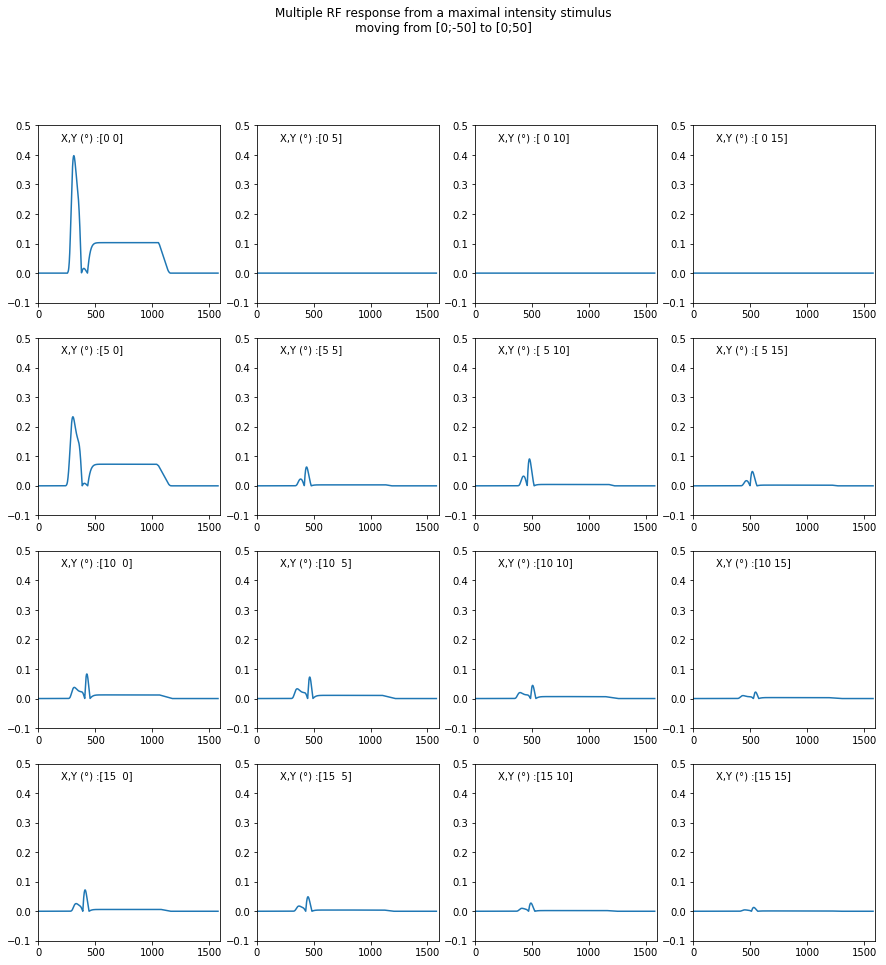

In [21]:
plt.figure(figsize=(15, 15))

for ft in range(len(Sts)):
    print('Calculating receptor field #%s'%ft)
    ax = plt.subplot(4, 4,ft+1)
    st_level = []
    for i in range(1580):
        st_level.append(np.max(Sts[ft][:,:,i]))
    ax.plot(st_level)
    ax.text(200, .45, "X,Y (°) :%s" % str(filters_coordinates[ft]-40))
    ax.set_xlim(0,1600)
    ax.set_ylim(-.1,.5)


#plt.tight_layout()
plt.suptitle(
    "Multiple RF response from a maximal contrast stimulus\nmoving from [0;-50] to [0;50]", x=.5, y=.99)
plt.savefig('./figs/2018_10_22_Multiple_RF.pdf', format = 'pdf', dpi = 200, bbox_inches = 'tight')